# Performing a convergence study

This example shows how to perform a convergence study to find an appropriate
discretisation parameters for the Brillouin zone (`kgrid`) and kinetic energy
cutoff (`Ecut`), such that the simulation results are converged to a desired
accuracy tolerance.

Such a convergence study is generally performed by starting with a
reasonalbe base line value for `kgrid` and `Ecut` and then increasing these
parameters (i.e. using finer discretisations) until a desired property (such
as the energy) changes less than the tolerance.

This procedure must be performed for each discretisation parameter. Beyond
the `Ecut` and the `kgrid` also convergence in the smearing temperature or
other numerical parameters should be checked. For simplicity we will neglect
this aspect in this example and concentrate on `Ecut` and `kgrid`. Moreover
we will restrict ourselves to using the same number of $k$-points in each
dimension of the Brillouin zone.

As the objective of this study we consider bulk platinum. For running the SCF conveniently we define a function:

In [1]:
using DFTK
using LinearAlgebra
using Statistics

function run_scf(; a=5.0, Ecut, nkpt, tol)
    atoms    = [ElementPsp(:Pt, psp = load_psp("hgh/lda/Pt-q10"))]
    position = [zeros(3)]
    lattice  = a * Matrix(I, 3, 3)

    model  = model_LDA(lattice, atoms, position; temperature=1e-2)
    basis  = PlaneWaveBasis(model; Ecut, kgrid=(nkpt, nkpt, nkpt))
    println("nkpt = $nkpt Ecut = $Ecut")
    self_consistent_field(basis; tol)
end;

Moreover we define some parameters. To make the calculations run fast for the
automatic generation of this documentation we target only a convergence to
1e-2. In practice smaller tolerances (and thus larger upper bounds for
`nkpts` and `Ecuts` are likely needed.

In [2]:
tol   = 1e-2      # Tolerance to which we target to converge
nkpts = 1:7       # K-point range checked for convergence
Ecuts = 10:2:24;  # Energy cutoff range checked for convergence

As the first step we converge in the number of kpoints employed in each
dimension of the Brillouin zone.

In [3]:
function converge_kgrid(nkpts; Ecut, tol)
    energies = [run_scf(; nkpt, tol=tol/10, Ecut).energies.total for nkpt in nkpts]
    errors = abs.(energies[1:end-1] .- energies[end])
    iconv = findfirst(errors .< tol)
    (; nkpts=nkpts[1:end-1], errors, nkpt_conv=nkpts[iconv])
end
result = converge_kgrid(nkpts; Ecut=mean(Ecuts), tol)
nkpt_conv = result.nkpt_conv

nkpt = 1 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -26.49669908630                   -0.22    9.0
  2   -26.58812156378       -1.04       -0.62    1.0
  3   -26.61280622327       -1.61       -1.40    2.0
  4   -26.61326644705       -3.34       -2.04    2.0
nkpt = 2 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -25.79139137255                   -0.09    5.2
  2   -26.23068913553       -0.36       -0.69    2.0
  3   -26.23814748480       -2.13       -1.32    2.0
  4   -26.23848506262       -3.47       -2.31    1.8
nkpt = 3 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -25.78365463650                   -0.09    4.8
  2   -26.23596196352       -0.34       -0.76    2.0
  3   -26.25072965117       -1.83       -1.64    2.0
  4   -26.25103349587       -3.52   

5

... and plot the obtained convergence:

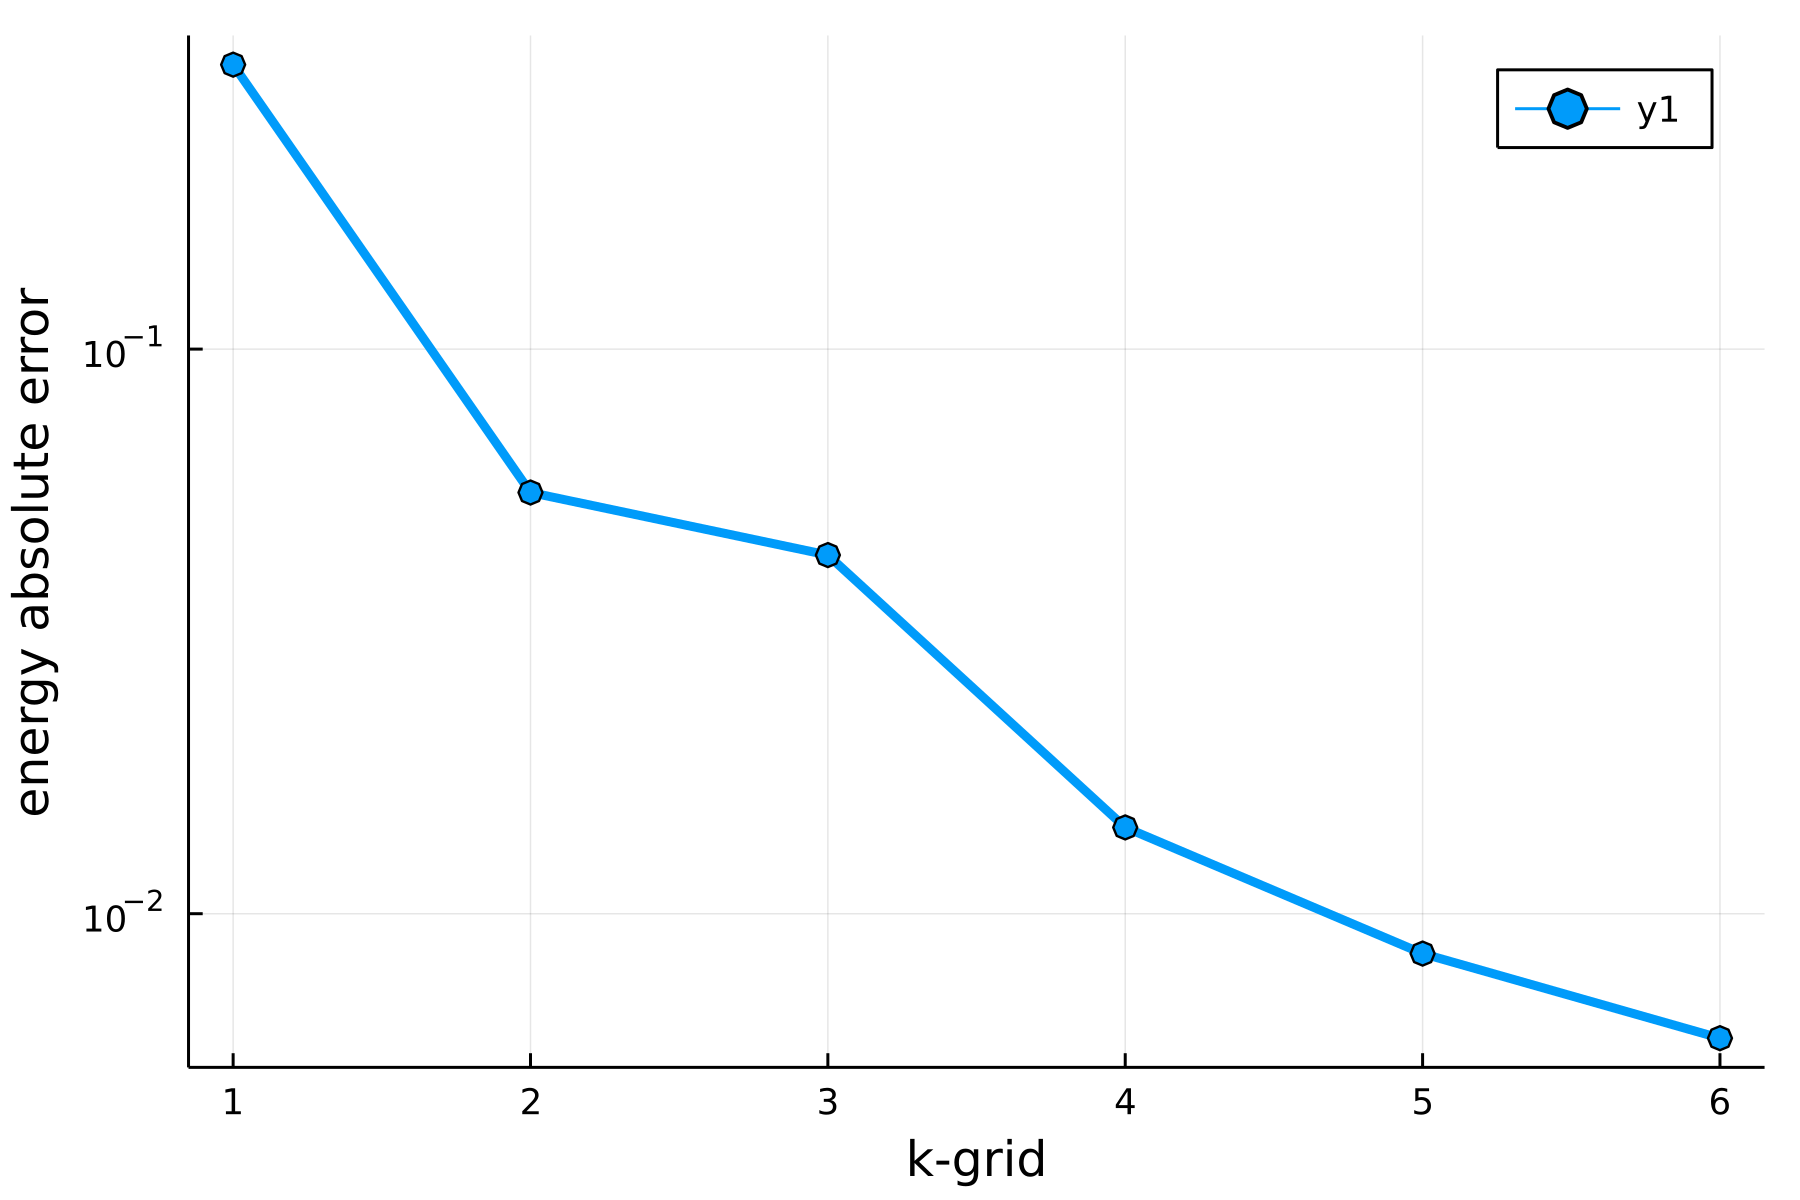

In [4]:
using Plots
plot(result.nkpts, result.errors, dpi=300, lw=3, m=:o, yaxis=:log,
     xlabel="k-grid", ylabel="energy absolute error")

We continue to do the convergence in Ecut using the suggested k-point grid.

In [5]:
function converge_Ecut(Ecuts; nkpt, tol)
    energies = [run_scf(; nkpt, tol=tol/100, Ecut).energies.total for Ecut in Ecuts]
    errors = abs.(energies[1:end-1] .- energies[end])
    iconv = findfirst(errors .< tol)
    (; Ecuts=Ecuts[1:end-1], errors, Ecut_conv=Ecuts[iconv])
end
result = converge_Ecut(Ecuts; nkpt=nkpt_conv, tol)
Ecut_conv = result.Ecut_conv

nkpt = 5 Ecut = 10
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -25.57965998448                   -0.16    3.3
  2   -25.77477401795       -0.71       -0.74    1.9
  3   -25.78626001587       -1.94       -1.87    2.0
  4   -25.78631882402       -4.23       -2.82    2.0
nkpt = 5 Ecut = 12
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -25.78778845120                   -0.12    3.5
  2   -26.07363300652       -0.54       -0.70    1.9
  3   -26.09343893627       -1.70       -1.70    2.0
  4   -26.09374102745       -3.52       -2.29    2.4
  5   -26.09375539268       -4.84       -2.82    2.1
nkpt = 5 Ecut = 14
n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -25.86872289410                   -0.11    3.6
  2   -26.20475881689       -0.47       -0.69    2.0
  3   -26.22672210777       -1.66       -1

18

... and plot it:

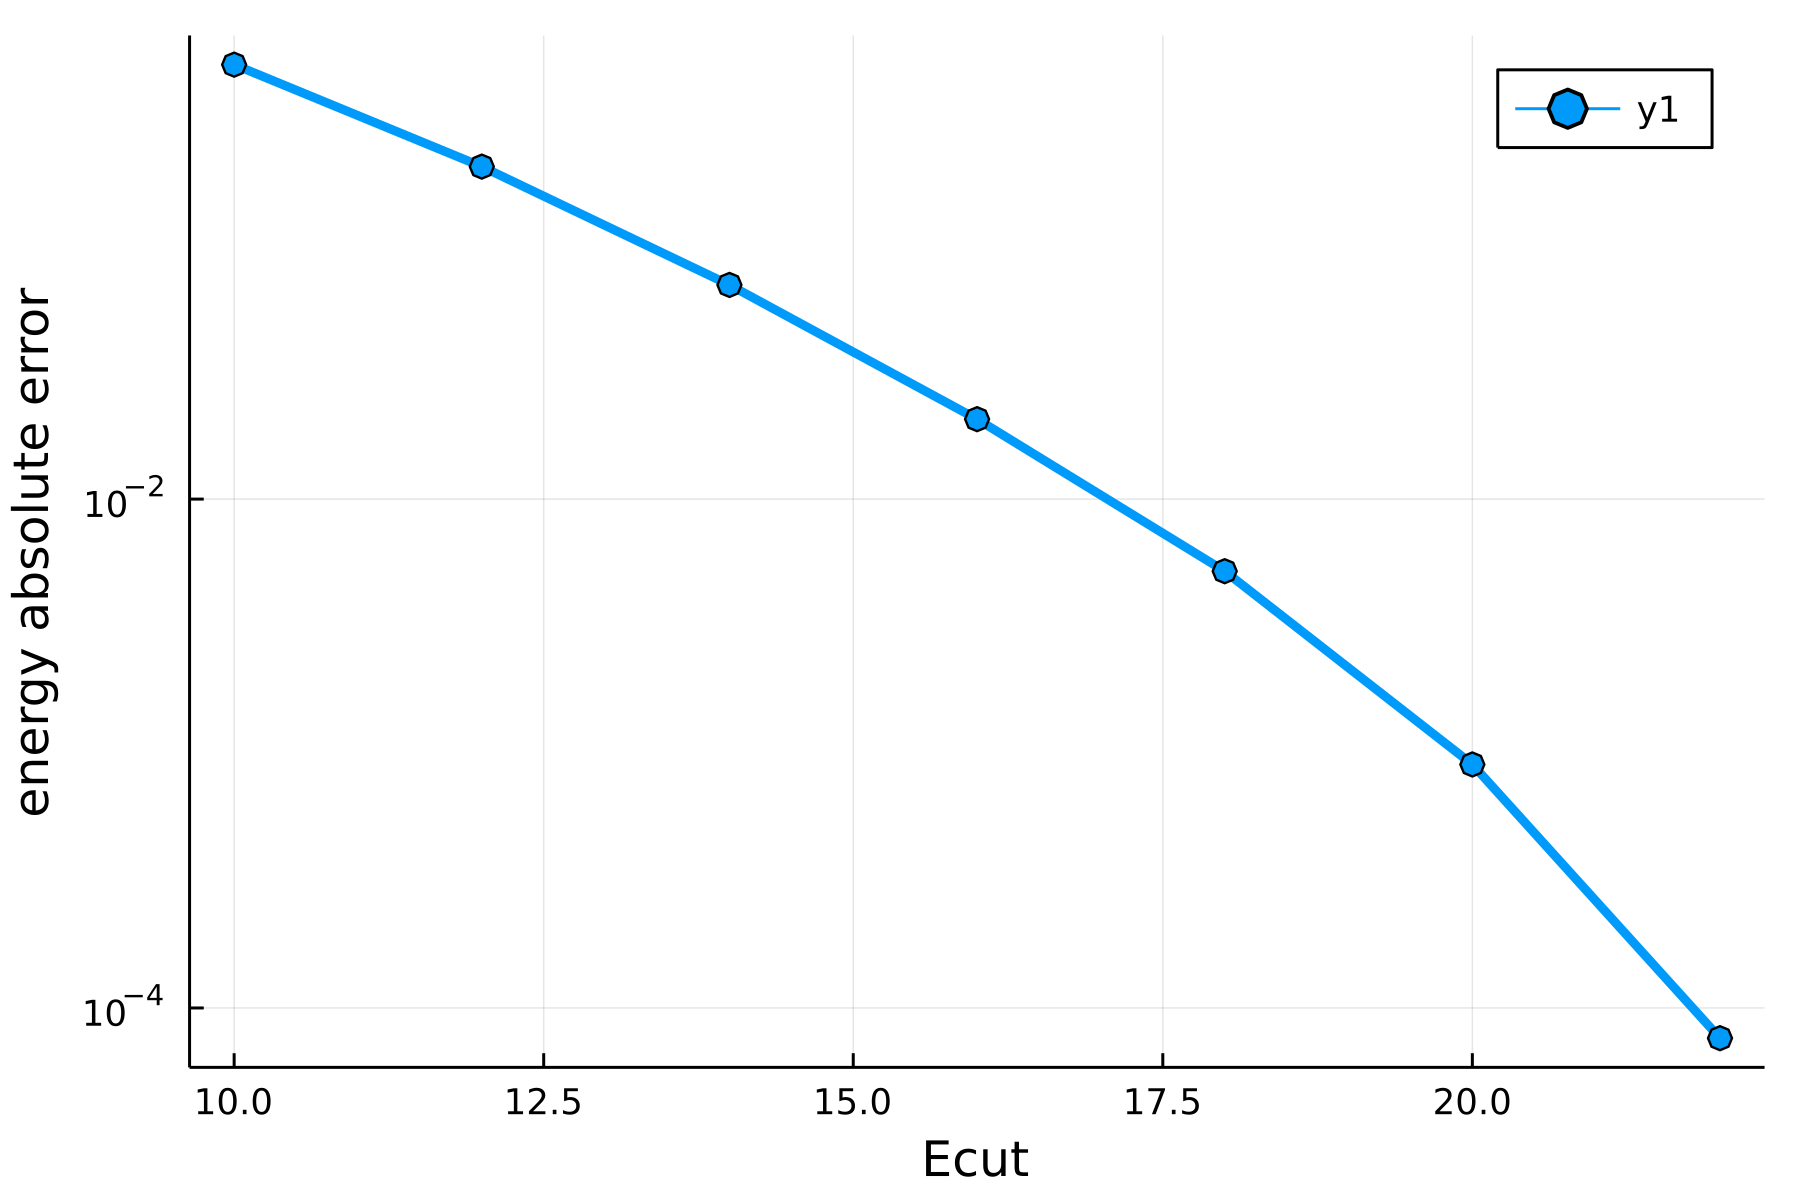

In [6]:
plot(result.Ecuts, result.errors, dpi=300, lw=3, m=:o, yaxis=:log,
     xlabel="Ecut", ylabel="energy absolute error")

## A more realistic example.
Repeating the above exercise for more realistic settings, namely ...

In [7]:
tol   = 1e-4  # Tolerance to which we target to converge
nkpts = 1:20  # K-point range checked for convergence
Ecuts = 20:1:50;

...one obtains the following two plots for the convergence in `kpoints` and `Ecut`.

<img src="https://docs.dftk.org/stable/assets/convergence_study_kgrid.png" width=600 height=400 />
<img src="https://docs.dftk.org/stable/assets/convergence_study_ecut.png"  width=600 height=400 />